<a href="https://colab.research.google.com/github/owl-d/Basic_DeepLearning/blob/main/Doit_Ch07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 다중 분류

***07-1 다중 분류하는 다층 신경망***

In [ ]:
#06장에서 다룬 class 모음

import numpy as np

class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x): #정방향 계산
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err): #역방향 계산
    m = len(x)                    #샘플의 개수
    w_grad = np.dot(x.T, err) / m #가중치에 대한 평균 그레디언트
    b_grad = np.sum(err) / m      #절편에 대한 평균 그레디언트
    return w_grad, b_grad

  def activation(self, z):  #활성화 함수 메서드
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  #forpass(), backprop() 메서드에서 전체 샘플 한 번에 계산하므로 각 샘플에 대한 두 번쨰 for문 사라짐
    y = y.reshape(-1, 1)  #target을 열 벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)
    m = len(x)            #샘플 개수
    self.w = np.ones((x.shape[1], 1))  #가중치 초기화
    self.b = 0                    #절편 초기화
    self.w_history.append(self.w.copy()) #가중치 기록
    for i in range(epochs):
      z = self.forpass(x)   #정방향 계산
      a = self.activation(z)   #활성화 함수 적용
      err = -(y - a)        #오차 계산
      w_grad, b_grad = self.backprop(x, err)  #역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m #L1규제와 L2규제 하나의 식으로 작성
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())
      a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑 한 후 손실 누적
      
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m) #로그 손실과 규제 손실 더해 리스트에 추가

      self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실 계산

  def predict(self, x):
    z = self.forpass(x)  #정방향 계산
    return z > 0         #계단 함수 적용(sigmoid 함수 적용하지 않아도 z의 값으로 알 수 있음)

  def score(self, x, y):  #모델의 정확도
    return np.mean(self.predict(x)==y.reshape(-1, 1)) #예측과 타깃 열 벡터 비교해 True의 비율 반환

  def reg_loss(self): #가중치에 규제 적용
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val): #검증 세트 손실 계산
    z = self.forpass(x_val) #정방향 계산
    a = self.activation(z)     #활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10) #출력값 클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a))) #로지스틱 손실 함수의 값 계산
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) #계산한 손실 함수 값 추가(L1, L2 규제 패널티 함수 포함)

class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units    #은닉층의 뉴런 개수
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []      #훈련 손실
    self.val_losses = []  #검증 손실
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1       #첫 번째 층의 선형식 계산
    self.a1 = self.activation(z1)           #활성화 함수 적용(SingleLayer클래스로부터 상속)
    z2 = np.dot(self.a1, self.w2) + self.b2 #두 번째 층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)      #샘플 개수
    #출력층의 가중치, 절편에 대한 gradient 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    #sigmoid 함수까지 gradient 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
    #은닉층의 가중치, 절편에 대한 gradient 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  #SingleLayer에서는 fit() 메서드를 한 덩어리로 작성했지만, DualLayer 클래스의 fit() 메서드는 3개의 작은 메서드로 쪼갠다.
  #1. 은닉층과 출력층의 가중치, 절편을 초기화
  #2. 에포크마다 정방향 계산 수행해 오차 계산
  #3. 오차 역전파해 가중치와 절편의 그레디언트 계산 및 업데이트
  #4. 손실 계산하여 누적

  def init_weights(self, n_features): #1
    self.w1 = np.ones((n_features, self.units)) #(특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)              #은닉층의 크기
    self.w2 = np.ones((self.units, 1))          #(은닉층의 크기, 1(=출력층의 크기))
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): #4
    y = y.reshape(-1, 1)               #타깃을 열벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)
    m = len(y)                        #샘플 개수
    self.init_weights(x.shape[1])     #은닉층, 출력층의 가중치 초기화
    for i in range(epochs):
      a = self.training(x, y, m)      #fit() 메서드의 for문 안에 있는 코드 중 일부를 training 메서드로 분리
      a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실
      self.losses.append((loss + self.reg_loss()) / m)  #로그 손실과 규제 손실 더해 리스트에 추가
      self.update_val_loss(x_val, y_val)                #검증 세트에 대한 손실 계산

  def training(self, x, y, m): #2,3
    z = self.forpass(x)       #정방향 계산 수행
    a = self.activation(z)    #활성화 함수 적용
    err = -(y - a)            #오차 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)      #오차 역전파 해 그레디언트 계산
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m #그레디언트에서 패널티 항 미분값 뺀다
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad  #은닉층 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad  #출력층 업데이트
    return a  #출력층의 활성화 출력 a 반환

  def reg_loss(self): #은닉층과 출력층의 가중치에 규제 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units)) #평균, 분산, (특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)                             #은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, 1))          #평균, 분산, (은닉층의 크기, 1)
    self.b2 = 0

class MinibatchNetwork(RandomInitNetwork):

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size  #배치 크기

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): #epoch 순회하는 for문 안에 미니 배치 순회하는 for문이 추가된다.
    y_val = y_val.reshape(-1, 1)
    self.init_weights(x.shape[1]) #은닉층과 출력층의 가중치 초기화
    np.random.seed(42)
    for i in range(epochs):
      loss = 0    #손실 초기화
      for x_batch, y_batch in self.gen_batch(x, y): #미니배치 순회
        y_batch = y_batch.reshape(-1, 1)    #타겟을 열 벡터로 바꾼다.
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) #매 미니배치마다 손실 누적
      self.losses.append((loss + self.reg_loss()) / len(x))            #로그 손실과 규제 손실 더해 리스트에 추가
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y): #미니 배치 만들어 반환
    length = len(x)
    bins = length // self.batch_size  #미니 배치 횟수
    if length % self.batch_size:
      bins += 1                       #나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))  #인덱스를 섞는다
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]  #batch_size만큼 슬라이싱하여 반환

In [ ]:
#다중 분류의 경사 하강법 알고리즘은 이진 분류의 경사 하강법 알고리즘과 원리는 같고 소프트맥스 함수가 추가된 점만 다르다.

import numpy as np
import matplotlib.pyplot as plt

class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y): #미니 배치 만들어 반환
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a #출력층의 활성화 출력 a 반환

    def predict(self, x): #정방향 계산에서 얻은 출력 중 가장 큰 값의 인덱스를 구한다. 이 값이 예측 클래스가 된다.
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다. #이진 분류에서와 마찬가지로 소프트맥스 거치지 않아도 z값만으로 클래스 예측 가능
    
    def score(self, x, y): #모델의 정확도 #predict() 매서드의 결과와 타깃 y(배열 y의 행을 따라 가장 큰 값의 인덱스 구하여) 비교
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self): #은닉층과 출력층의 가중치에 규제 적용
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val): #검증 세트 손실 계산
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

Fashion MNIST 데이터 세트 이용해 의류 이미지 분류하기(흑백)

In [ ]:
#1. 텐서플로 최신 버전 설치
!pip install tensorflow_gpu==2.0.0

     |████████████████████████████████| 380.8 MB 38 kB/s 
     |████████████████████████████████| 3.8 MB 30.7 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 449 kB 47.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=6b821d62048c58243197cc0757d511e4b69dde73eb74b13e6c86bf9d5cf040fc
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
#2. 텐서플로 버전 확인하기

import tensorflow as tf

tf.__version__

'2.5.0'

In [ ]:
#3. 패션 MNIST 데이터 세트 불러오기

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#4. 훈련 세트의 크기 확인하기

print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


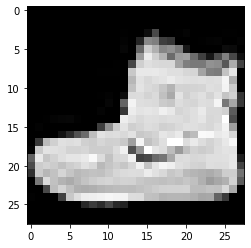

In [ ]:
#5. imshow() 함수로 샘플 이미지 확인하기

import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray') #0번쨰 요소 확인
plt.show()

In [ ]:
#6. 타깃의 내용과 의미 확인하기

print(y_train_all[:10]) #가장 앞에 있는 데이터 10개의 target의 class label 출력

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

print(class_names[y_train_all[0]]) #첫 번째 샘플의 클래스

앵클부츠


In [ ]:
#7. 타깃 분포 확인하기

np.bincount(y_train_all) #각 클래스 당 샘플이 몇 개씩 있는지 확인

#label 당 6000개의 데이터가 존재한다.

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
#8. 훈련 세트와 검증 세트 고르게 나누기

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

#훈련, 검증 세트의 레이블이 잘 나누어졌는지 확인 -> 80:20의 비율로 나누어짐
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [ ]:
#9. 입력 데이터 정규화하기 : '표준화'했다고 말할 수 없지만 잘 작동

x_train = x_train / 255
x_val = x_val / 255

In [ ]:
#10. 훈련 세트와 검증 세트의 차원 변경하기
#기존 28X28 크기의 2차원 배열이나, 네트워크에는 1차원 배열의 샘플을 입력해야 하므로 이어붙인다.

x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


타깃 데이터 변환

In [ ]:
#1. 타깃을 원-핫 인코딩으로 변환
#타깃값들은 0~9 사이의 정수값 중 하나로 10개의 출력 뉴런에 대응되지 않는다. 따라서 이에 대응하는 배열로 변환한다.
#타깃의 정수값에 해당하는 원소는 1, 나머지 원소는 모두 0으로 하여 10개의 원소를 가진 배열로 만든다.

#아래는 to_categorical을 사용해 원-핫 인코딩을 하는 예시
print(tf.keras.utils.to_categorical([0, 1, 3]))

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape) #변환된 원-핫 인코딩 배열의 크기

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
(48000, 10) (12000, 10)


In [ ]:
#2. 만든 배열의 각 원소를 뉴런의 출력값과 비교하여, 가장 큰 출력값이 인덱스가 타깃과 동일한지 비교

print(y_train[0], y_train_encoded[0]) #첫 번째 label 6 출력해보기

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


MultiClassNetwork 클래스로 다중 분류 신경망 훈련하기

In [ ]:
#MultiClassNetwork 클래스로 다중 분류 신경망 훈련하기

fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

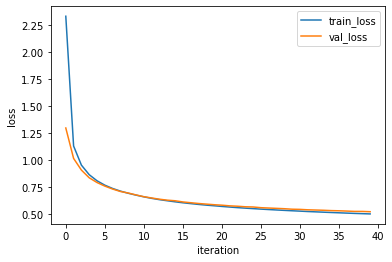

In [ ]:
#훈련 손실, 검증 손실 그래프 확인하기

plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#손실 그래프가 초기에는 빠르게 감소하다가 완만하게 수렴

In [ ]:
#훈련 모델 점수 확인

fc.score(x_val, y_val_encoded)

0.8150833333333334

***07-2 텐서플로와 케라스 이용해 신경망 만들기***

In [ ]:
#간단한 신경망을 텐서플로로 구현 #왜 안 돼

#훈련할 가중치 변수 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

#경사하강법 옵티마이저 설정
optimizer = tf.optimizers.SGD(lr = 0.01)
#epoch 만큼 훈련
num_epochs = 10
for step in range(num_epochs):

  #자동 미분을 위해 연산 과정 기록
  with tf.GradientTape() as tape:
    z_net = w * x_train + b
    z_net = tf.reshape(z_net, [-1])
    sqr_errors = tf.square(y_train - z_net)
    mean_cost = tf.reduce_mean(sqr_errors)
  #손실 함수에 대한 가중치의 gradient 계산
  grads = tape.gradient(mean_cost, [w, b])
  #옵티마이저에 그레디언트 반영
  optimizer.apply_gradients(zip(grads, [w, b]))

In [ ]:
#신경망을 케라스로 구현 : 간단하다.

#신경망 모델 만든다.
model = tf.keras.models.Sequential()
#완전 연결층 추가
model.add(tf.keras.layers.Dense(1))
#옵티마이저, 손실 함수 지정
model.compile(optimizer='sgd', loss='mse')
#훈련 데이터 사용해 epoch 횟수만큼 훈련
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 3s 1ms/step - loss: nan
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 8/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 9/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 10/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan


In [ ]:
#Sequential 클래스 사용법 : 인공신경망 모델 만듦

#1. Sequential 클래스의 객체를 생성할 때 Dense 클래스로 만든 층을 추가
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([Dense(...), ...]) #신경망 모델에 추가할 층을 파이썬 리스트로 만들어 전달하면 Sequential 클래스의 객체가 만들어질 때 층이 추가된다.

#2. 객체를 생성한 후 add() method 사용해 층을 추가
dense = Dense(...)
model.add(dense)

#or Dense 클래스 객체 만들어 바로 전달도 가능

model = Sequential()
model.add(Dense(...))
model.add(Dense(...))

In [ ]:
#Dense 클래스 사용법 : fully connected layer 만듦

Dense(unit=100, activation='sigmoid')
#units : 뉴런의 개수(하이퍼파라미터)
#activation : 활성화 함수 지정. 기본값은 'None'이므로 지정하지 않으면 활성화 함수 적용되지 않는다.

케라스로 다중 분류 신경망 만들기

In [ ]:
#1. 모델(Sequential 객체) 생성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [ ]:
#2. 은닉층과 출력층을 모델에 추가
model.add(Dense(100, activation='sigmoid', input_shape=(784,))) #은닉층의 유닛 개수는 100개, 활성화 함수는 sigmoid 함수,
                                                #입력 데이터의 크기는 28X28=784, 입력 행렬의 첫번쨰 차원인 입력 데이터의
                                                #개수는 신경망 구성에 불필요하므로 입력하지 않는다. 
model.add(Dense(10, activation='softmax'))                      #출력층의 유닛 개수는 10개, 활성화 함수는 softmax 함수

In [ ]:
#3. 최적화 알고리즘과 손실 함수 지정하기
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#optimizer : 최적화 알고리즘. 'sgd'는 기본 경사 하강법이고, learning rate의 기본값은 0.01이다.
#loss : 손실함수. 'categorical_crossentropy'는 크로스 엔트로피 손실 함수이다.
#metrics : 훈련 과정 기록으로 정확도 남기기 위해 추가. 지정하지 않으면 기본값으로 손실값(loss)가 기록된다.

In [ ]:
#4. 모델 훈련하기
#검증 세트에 대한 손실과 정확도 계산 위해 validation_data 매개변수에 검증 세트를 튜플로 전달
#fit() mothod는 훈련 세트와 검증 세트에서 측정한 값들을 History 클래스 객체에 담아 반환

history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3973 - accuracy: 0.6417 - val_loss: 0.9689 - val_accuracy: 0.7369
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8472 - accuracy: 0.7449 - val_loss: 0.7541 - val_accuracy: 0.7608
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7132 - accuracy: 0.7634 - val_loss: 0.6649 - val_accuracy: 0.7805
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6475 - accuracy: 0.7791 - val_loss: 0.6147 - val_accuracy: 0.7867
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6057 - accuracy: 0.7926 - val_loss: 0.5792 - val_accuracy: 0.7977
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.5514 - val_accuracy: 0.8093
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5523 - accuracy: 0.8100 - val_loss: 0.5315 - val_accuracy:

In [ ]:
#5. 손실과 정확도 그래프 그리기
#반환된 history dictionary의 키를 출력해보면 어떤 측정 지표들이 들어가 있는지 확인 가능
print(history.history.keys())

#차례대로 훈련 세트에서의 손실, 검증 세트에서의 손실, 훈련 세트의 정확도, 검증 세트의 정확도

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


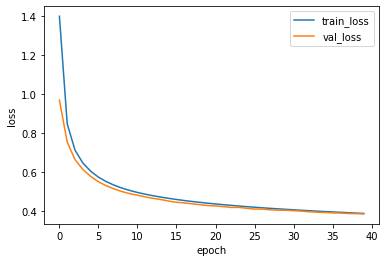

In [ ]:
#훈련 세트와 검증 세트의 손실 그래프 나타낸 그래프

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#일정한 수준으로 감소

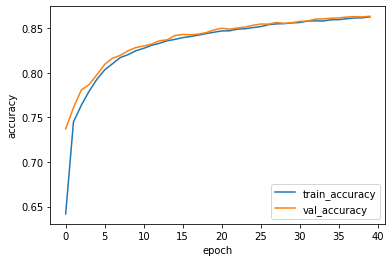

In [ ]:
#훈련 세트와 검증 세트의 정확도 나타낸 그래프

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#점진적으로 증가하는 추세

In [ ]:
#6. 검증 세트 정확도 계산하기
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8632500171661377


In [ ]:
#7. 테스트 세트 정확도 계산하기